In [2]:
pip install laspy[laszip]

Note: you may need to restart the kernel to use updated packages.


In [54]:
# -*- coding: utf-8 -*-

In [8]:
import numpy as np
import laspy

with laspy.open(r"E:\RTE_entrainement\IA_Train_Valid_Test\Dev_YSO_py\pred_25.laz") as fh:
    print('Points from Header:', fh.header.point_count)
    las = fh.read()
    print(las)
    print(las.xyz.shape)
    print('Points from data:', len(las.points))
    unique_classes,class_counts= np.unique(las.classification, return_counts=True)
    class_counts = dict(zip(unique_classes, class_counts))
    print(unique_classes)
    print(len(unique_classes))
    ground_pts = las.classification
   
    
    bins_g, counts_g = np.unique(las.return_number[ground_pts], return_counts=True)
    print('Ground Point Return Number distribution:')
    for r,c in zip(bins_g,counts_g):
        print('  {}:{}'.format(r,c))
        
    for clas in unique_classes:
        print(f'{clas},":", {las.xyz}')
        
    print(ground_pts)
    print(las.points)
  

Points from Header: 80384469
<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 80384469 points, 2 vlrs)>
(80384469, 3)
Points from data: 80384469
[0 1 2 3 4 5 6]
7
Ground Point Return Number distribution:
  2:73812
  3:15518469
  4:58803705
  5:5988483
0,":", [[ 6.56972220e+05  6.38911833e+06 -2.26380000e+02]
 [ 6.56971330e+05  6.38911975e+06 -2.23730000e+02]
 [ 6.56969840e+05  6.38912390e+06 -2.25880000e+02]
 ...
 [ 6.57414160e+05  6.38944558e+06  6.32590000e+02]
 [ 6.57414160e+05  6.38944559e+06  6.32820000e+02]
 [ 6.57414120e+05  6.38944565e+06  6.32810000e+02]]
1,":", [[ 6.56972220e+05  6.38911833e+06 -2.26380000e+02]
 [ 6.56971330e+05  6.38911975e+06 -2.23730000e+02]
 [ 6.56969840e+05  6.38912390e+06 -2.25880000e+02]
 ...
 [ 6.57414160e+05  6.38944558e+06  6.32590000e+02]
 [ 6.57414160e+05  6.38944559e+06  6.32820000e+02]
 [ 6.57414120e+05  6.38944565e+06  6.32810000e+02]]
2,":", [[ 6.56972220e+05  6.38911833e+06 -2.26380000e+02]
 [ 6.56971330e+05  6.38911975e+06 -

In [97]:
# -*- coding: utf-8 -*-
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import laspy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,jaccard_score
import matplotlib.pyplot as plt 

# Here, we're going to set, useful fonctions or potentialy useful 

def fIoU (tp,fp,fn) :
    return tp / (tp + fp + fn)
#intersection over union


# Foncton to calculate the precision of our model prediction
def Metricsecall (tp,fn) :
    
    #nombre : nombre de points classifiés dans une certaine classe par le nuage de référence
    if (tp+fn) == 0 :
        return 0
    else :
        return tp/(tp+fn)
    
def faccuracy(tp,fp,fn):
    return tp/(tp+fp+fn)
    
#nombre de points dans la même classification (les true points en cas de nuage de référence) / nombre de point de la classe 
#spécifique dans le nuage 1
#qualitativement c'est la proportion de points correctements classifiés par rapport aux points dans la classif
# recall == 1 signifie que l'algo n'omet pas de points


# Foncton to calculate the precision of our model prediction

def fprecision (tp,fp) :
    if (tp+fp) == 0 :
        return 0
    else :
        return tp/(tp+fp)
# precision == 1 signifie que que l'algo ne prend pas de points en trop

# here, is for a specific comparison between precision and the recall 
def ff1score (precision,rappel) :
    if (precision+rappel) < 10**-5 :
        return 0
    return 2*(precision*rappel)/(precision+rappel)


# This fonction retutrns general inforrmation about the file
# possible to edit the script in oder to define your own output willing

def infos_class(file_path):
    with laspy.open(file_path) as fh:
        print('Points Metricsom Header:', fh.header.point_count)
        las = fh.read()
        #print(las.xyz.shape)
        print('Points Metricsom data:', len(las.points))
        #unique_classes,class_counts= np.unique(las.classification, return_counts=True)
        #class_counts = dict(zip(unique_classes, class_counts))
        #print(class_counts)
        #  Display number of return
        ground_pts = las.classification
        bins_g, counts_g = np.unique(las.return_number[ground_pts], return_counts=True)
        print('Ground Point Return Number distribution:')
        for r,c in zip(bins_g,counts_g):
            print('    {}:{}'.format(r,c))







# This part is only for reading las files
# It returns something like this: with the number of points
#<LasData(1.4, point fmt: <PointFormat(6, 8 bytes of extra dims)>, 1258912 points, 1 vlrs)>

def read_file(file_path):
    with laspy.open(file_path) as fh:
        data=fh.read()
    return data
#
# reading data and  extracting specific information, 
# like the occurences of classes in the file

def read_file_class(file_path):
    with laspy.open(file_path) as fh:
        data=fh.read()
    return data.classification
#
# This fonction will help us to  extract data label (different existing classes inside las files)

def data_label(las):
    unique_classes,class_counts= np.unique(las.classification, return_counts=True)
    class_counts = dict(zip(unique_classes, class_counts))    
    return unique_classes

# this fonction is for Extracting Data 3D cordonnates Metricsom laZ files
def label_xyz(las):
    label_xyz = las.xyz
    return label_xyz


# this fonction allow to count number of points in a class
def count_points_per_class(file_path):
    class_counts = {}
    with laspy.open(file_path) as fh:
        las = fh.read()
        unique_classes, class_counts = np.unique(las.classification, return_counts=True)
        class_counts = dict(zip(unique_classes, class_counts))
    return class_counts




def num_points(classe1):
    num_point_clas1=[]
    for el in range(len(classe1)):
        num_point_clas1.append((classe1[el]))
    return num_point_clas1


def compute_confusion_matrix(ground_truth,predictions):
    """
    Calcule la matrice de confusion pour les prédictions et les classes réelles.
    
    Args:
        predictions (numpy.ndarray): Tableau des prédictions du modèle.
        ground_truth (numpy.ndarray): Tableau des classes réelles.
    
    Returns:
        pandas.DataMetricsame: Matrice de confusion avec les index et colonnes représentant les classes.
    """
    # Identifiez les classes uniques présentes dans ground_truth et predictions
    unique_classes = np.unique(np.concatenate((predictions, ground_truth)))
    #print(unique_classes)

    # Créez une matrice de confusion basée uniquement sur les classes uniques
    confusion_matrix = np.zeros((len(unique_classes), len(unique_classes)))

    # Remplissez la matrice de confusion uniquement pour les classes existantes
    for i in range(len(predictions)):
        pred_class = predictions[i]
        true_class = ground_truth[i]
        pred_index = np.where(unique_classes == pred_class)[0][0]
        true_index = np.where(unique_classes == true_class)[0][0]
        confusion_matrix[pred_index, true_index] += 1

    # Créez des titres de classe basés sur les classes uniques
    class_titles = [f"Classe {c}" for c in unique_classes]

    # Créez le DataMetricsame de la matrice de confusion avec les titres de classe
    conf_matrix_df = pd.DataFrame(confusion_matrix, index=class_titles, columns=class_titles)
    #conf_matrix_df.to_csv('E:\RTE_entrainement\IA_Train_Valid_Test\Test_YSO_py\confusion_matrix.csv')
    return conf_matrix_df




class Metrics:
    
    def __init__(self, true_labels, pred_labels) :
        self.true_labels=true_labels
        self.pred_labels=pred_labels

    def compute_metrics(self):
        """ return metrics by class"""
        IoU=jaccard_score(self.true_labels, self.pred_labels, average=None)
        precision = precision_score(self.true_labels, self.pred_labels, average=None,zero_division='warn')
        recall = recall_score(self.true_labels, self.pred_labels, average=None,zero_division='warn')
        f1 = f1_score(self.true_labels, self.pred_labels, average=None)
        accuracy = accuracy_score(self.true_labels, self.pred_labels)
        
        metrics_dict = {
        'IoU': IoU,
        'Recall': recall,
        'Precision': precision,
        'F1_score': f1,
        'Accuracy': accuracy
    }
        return metrics_dict
    
    def metrics_frame(self,results):
        unique_classes = np.unique(np.concatenate((self.true_labels, self.pred_labels)))
        # Créez des titres de classe basés sur les classes uniques
        class_titles = [f"Classe {c}" for c in unique_classes]
        nam_metrics = ['IoU', 'Recall', 'Precision', 'F1_score', 'Accuracy']
        Metrics = np.zeros((5, len(results['IoU'])))
        
        for i, metric_name in enumerate(nam_metrics):
            Metrics[i] = results[metric_name]
        ##
        """
        IoU=jaccard_score(self.true_labels, self.pred_labels, average=None)
        precision = precision_score(self.true_labels, self.pred_labels, average=None,zero_divimetrics.weighted_metrics()sion='warn')
        recall = recall_score(self.true_labels, self.pred_labels, average=None,zero_division='warn')
        f1 = f1_score(self.true_labels, self.pred_labels, average=None)
        accuracy = accuracy_score(self.true_labels, self.pred_labels)"""
    
        #  
        # Créez le DataMetricsame de la matrice de confusion avec les titres de classe
        Metrics_df = pd.DataFrame(Metrics, index=nam_metrics, columns=class_titles)
        Metrics_df.index.name = 'Métriques'
        Metrics_df.columns.name = 'Valeurs des métriques'
        return Metrics_df
        
        
    def weighted_metrics(self):
        
        """Calculate metrics for each label, and find their average weighted 
        by support (the number of true instances for each label)"""
        
        IoU_w=jaccard_score(self.true_labels, self.pred_labels, average="weighted")
        precision_w = precision_score(self.true_labels, self.pred_labels, average='weighted',zero_division='warn')
        recall_w = recall_score(self.true_labels, self.pred_labels, average='weighted',zero_division='warn')
        f1_w = f1_score(self.true_labels, self.pred_labels, average='weighted')
        accuracy = accuracy_score(self.true_labels, self.pred_labels)
        
        nam_metrics = ['IoU', 'Recall','precision','Accuracy', 'F1_score']
        weigh_metrics=[IoU_w,recall_w,precision_w,f1_w,accuracy]
        weigh_metrics_df=pd.DataFrame({'Valeurs': weigh_metrics}, index=nam_metrics)
        weigh_metrics_df.index.name = 'Métriques'
        
        return weigh_metrics_df
        
        
        
        
    def graphmetrics(self,metrics_data):        
        data=np.arange(1, len(metrics_data['IoU'])+1)
        plt.figure(figsize=(15,7))
        # Tracé des métriques
        for metric, values in metrics_data.items():
            if metric != 'Accuracy':             
                plt.plot(data, values, label=metric)
        
        # Ajout de légendes et de titres
        plt.xlabel('Classes')
        plt.ylabel('Valeur')
        plt.title('Métriques par classe')
        plt.legend()
        plt.grid(True)

            # Affichage du graphique
        plt.tight_layout()
        plt.show()
            
    
    def n_graphmetrics(self, metrics_data):        
        data = np.arange(1, len(metrics_data['IoU']) + 1)
        metrics_to_plot = [metric for metric in metrics_data if metric != 'Accuracy']
        num_metrics = len(metrics_to_plot)
        
        fig, axes = plt.subplots(num_metrics, 1, figsize=(15, 7*num_metrics))
        
        for i, (metric, values) in enumerate(metrics_data.items()):
            if metric != 'Accuracy':
                ax = axes[i] if num_metrics > 1 else axes  # Utiliser le même axe s'il n'y a qu'une seule métrique
                ax.plot(data, values, label=metric)
                ax.set_xlabel('Classes')
                ax.set_ylabel('Valeur')
                ax.set_title(f'Métrique: {metric}')
                ax.legend()
                ax.grid(True)  # Ajout de la grille
                
        plt.tight_layout()
        plt.show()


In [94]:
# Exemple d'utilisation
c1=read_file_class(r"E:\RTE_entrainement\IA_Train_Valid_Test\Dev_YSO_py\pred_25.laz")
c2=read_file_class(r"E:\RTE_entrainement\IA_Train_Valid_Test\Dev_YSO_py\before_25.laz")
num_classe1=num_points(c1)
num_classe2=num_points(c2)
predictions = np.array(num_classe1)
ground_truth = np.array(num_classe2)
#class_titles = ["Classe 0", "Classe 1","classes2","classe3"]
conf_matrix = compute_confusion_matrix(ground_truth,predictions)

print("Matrice de confusion :\n", conf_matrix)

## Instancing
metrics=Metrics(ground_truth,predictions)
## calling a methods for computing metrics
af=metrics.compute_metrics()
metrics.weighted_metrics()
## for displaying as frame
metrics.metrics_frame(af)

#metrics.graphmetrics(af)


#compute_metrics_per_class(ground_truth,predictions)
#calculate_metrics(conf_matrix.values)


#calculate_metrics(conf_matrix.values)

# Écrire le DataFrame dans un fichier CSV



Matrice de confusion :
             Classe 0  Classe 1   Classe 2    Classe 3  Classe 4    Classe 5  \
Classe 0         0.0     542.0    17321.0   1466175.0       0.0   2043702.0   
Classe 1         0.0   50901.0  2141540.0  56523912.0       0.0     49454.0   
Classe 2         0.0     668.0    11323.0    467691.0       0.0  14852508.0   
Classe 3         0.0    5665.0    98069.0   1661692.0       0.0    514824.0   
Classe 4         0.0      17.0       87.0       536.0       0.0     54425.0   
Classe 5         0.0       0.0        0.0         0.0       0.0         0.0   
Classe 6         0.0       0.0        0.0         0.0       0.0     20387.0   
Classe 7         0.0       0.0        0.0         0.0       0.0         0.0   
Classe 9         0.0       0.0        0.0         0.0       0.0         0.0   
Classe 14        0.0       0.0        0.0         0.0       0.0         0.0   
Classe 56        0.0       0.0        0.0         0.0       0.0         0.0   
Classe 68        0.0       0

c:\Users\ysouley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ysouley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ysouley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Valeurs des métriques,Classe 0,Classe 1,Classe 2,Classe 3,Classe 4,Classe 5,Classe 6,Classe 7,Classe 9,Classe 14,...,Classe 79,Classe 102,Classe 152,Classe 153,Classe 196,Classe 197,Classe 200,Classe 211,Classe 212,Classe 213
Métriques,,,,,,,,,,,,,,,,,,,,,
IoU,0.000000,0.000866,0.000637,0.027358,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall,0.000000,0.880747,0.004992,0.027640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Precision,0.000000,0.000866,0.000730,0.728406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F1_score,0.000000,0.001730,0.001273,0.053258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Accuracy,0.021446,0.021446,0.021446,0.021446,0.021446,0.021446,0.021446,0.021446,0.021446,0.021446,...,0.021446,0.021446,0.021446,0.021446,0.021446,0.021446,0.021446,0.021446,0.021446,0.021446


In [47]:
metrics.weighted_metrics()

c:\Users\ysouley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ysouley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Valeurs
Métriques,
IoU,0.020480
Recall,0.021446
precision,0.544800
Accuracy,0.039869
F1_score,0.021446


Matrice de confusion :
             Classe 0  Classe 1   Classe 2    Classe 3  Classe 4    Classe 5  \
Classe 0         0.0     542.0    17321.0   1466175.0       0.0   2043702.0   
Classe 1         0.0   50901.0  2141540.0  56523912.0       0.0     49454.0   
Classe 2         0.0     668.0    11323.0    467691.0       0.0  14852508.0   
Classe 3         0.0    5665.0    98069.0   1661692.0       0.0    514824.0   
Classe 4         0.0      17.0       87.0       536.0       0.0     54425.0   
Classe 5         0.0       0.0        0.0         0.0       0.0         0.0   
Classe 6         0.0       0.0        0.0         0.0       0.0     20387.0   
Classe 7         0.0       0.0        0.0         0.0       0.0         0.0   
Classe 9         0.0       0.0        0.0         0.0       0.0         0.0   
Classe 14        0.0       0.0        0.0         0.0       0.0         0.0   
Classe 56        0.0       0.0        0.0         0.0       0.0         0.0   
Classe 68        0.0       0

c:\Users\ysouley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ysouley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


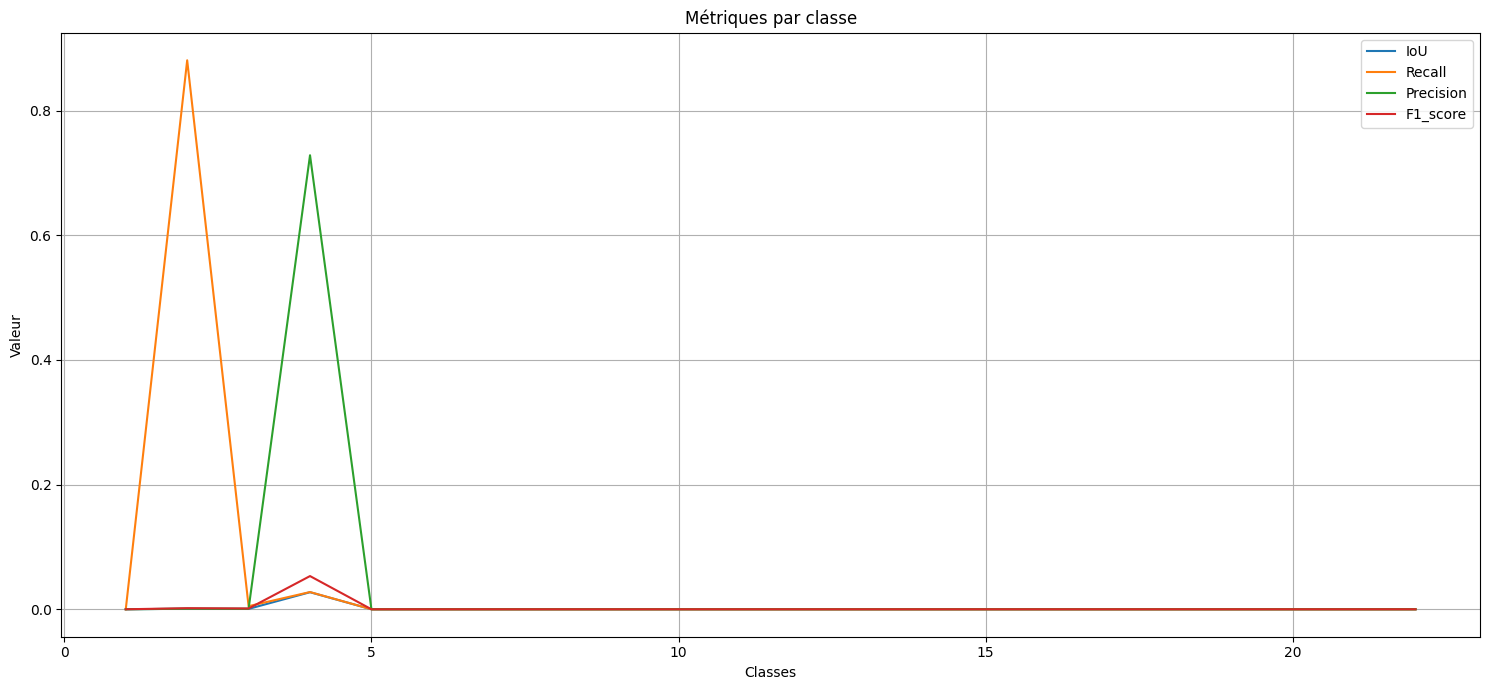

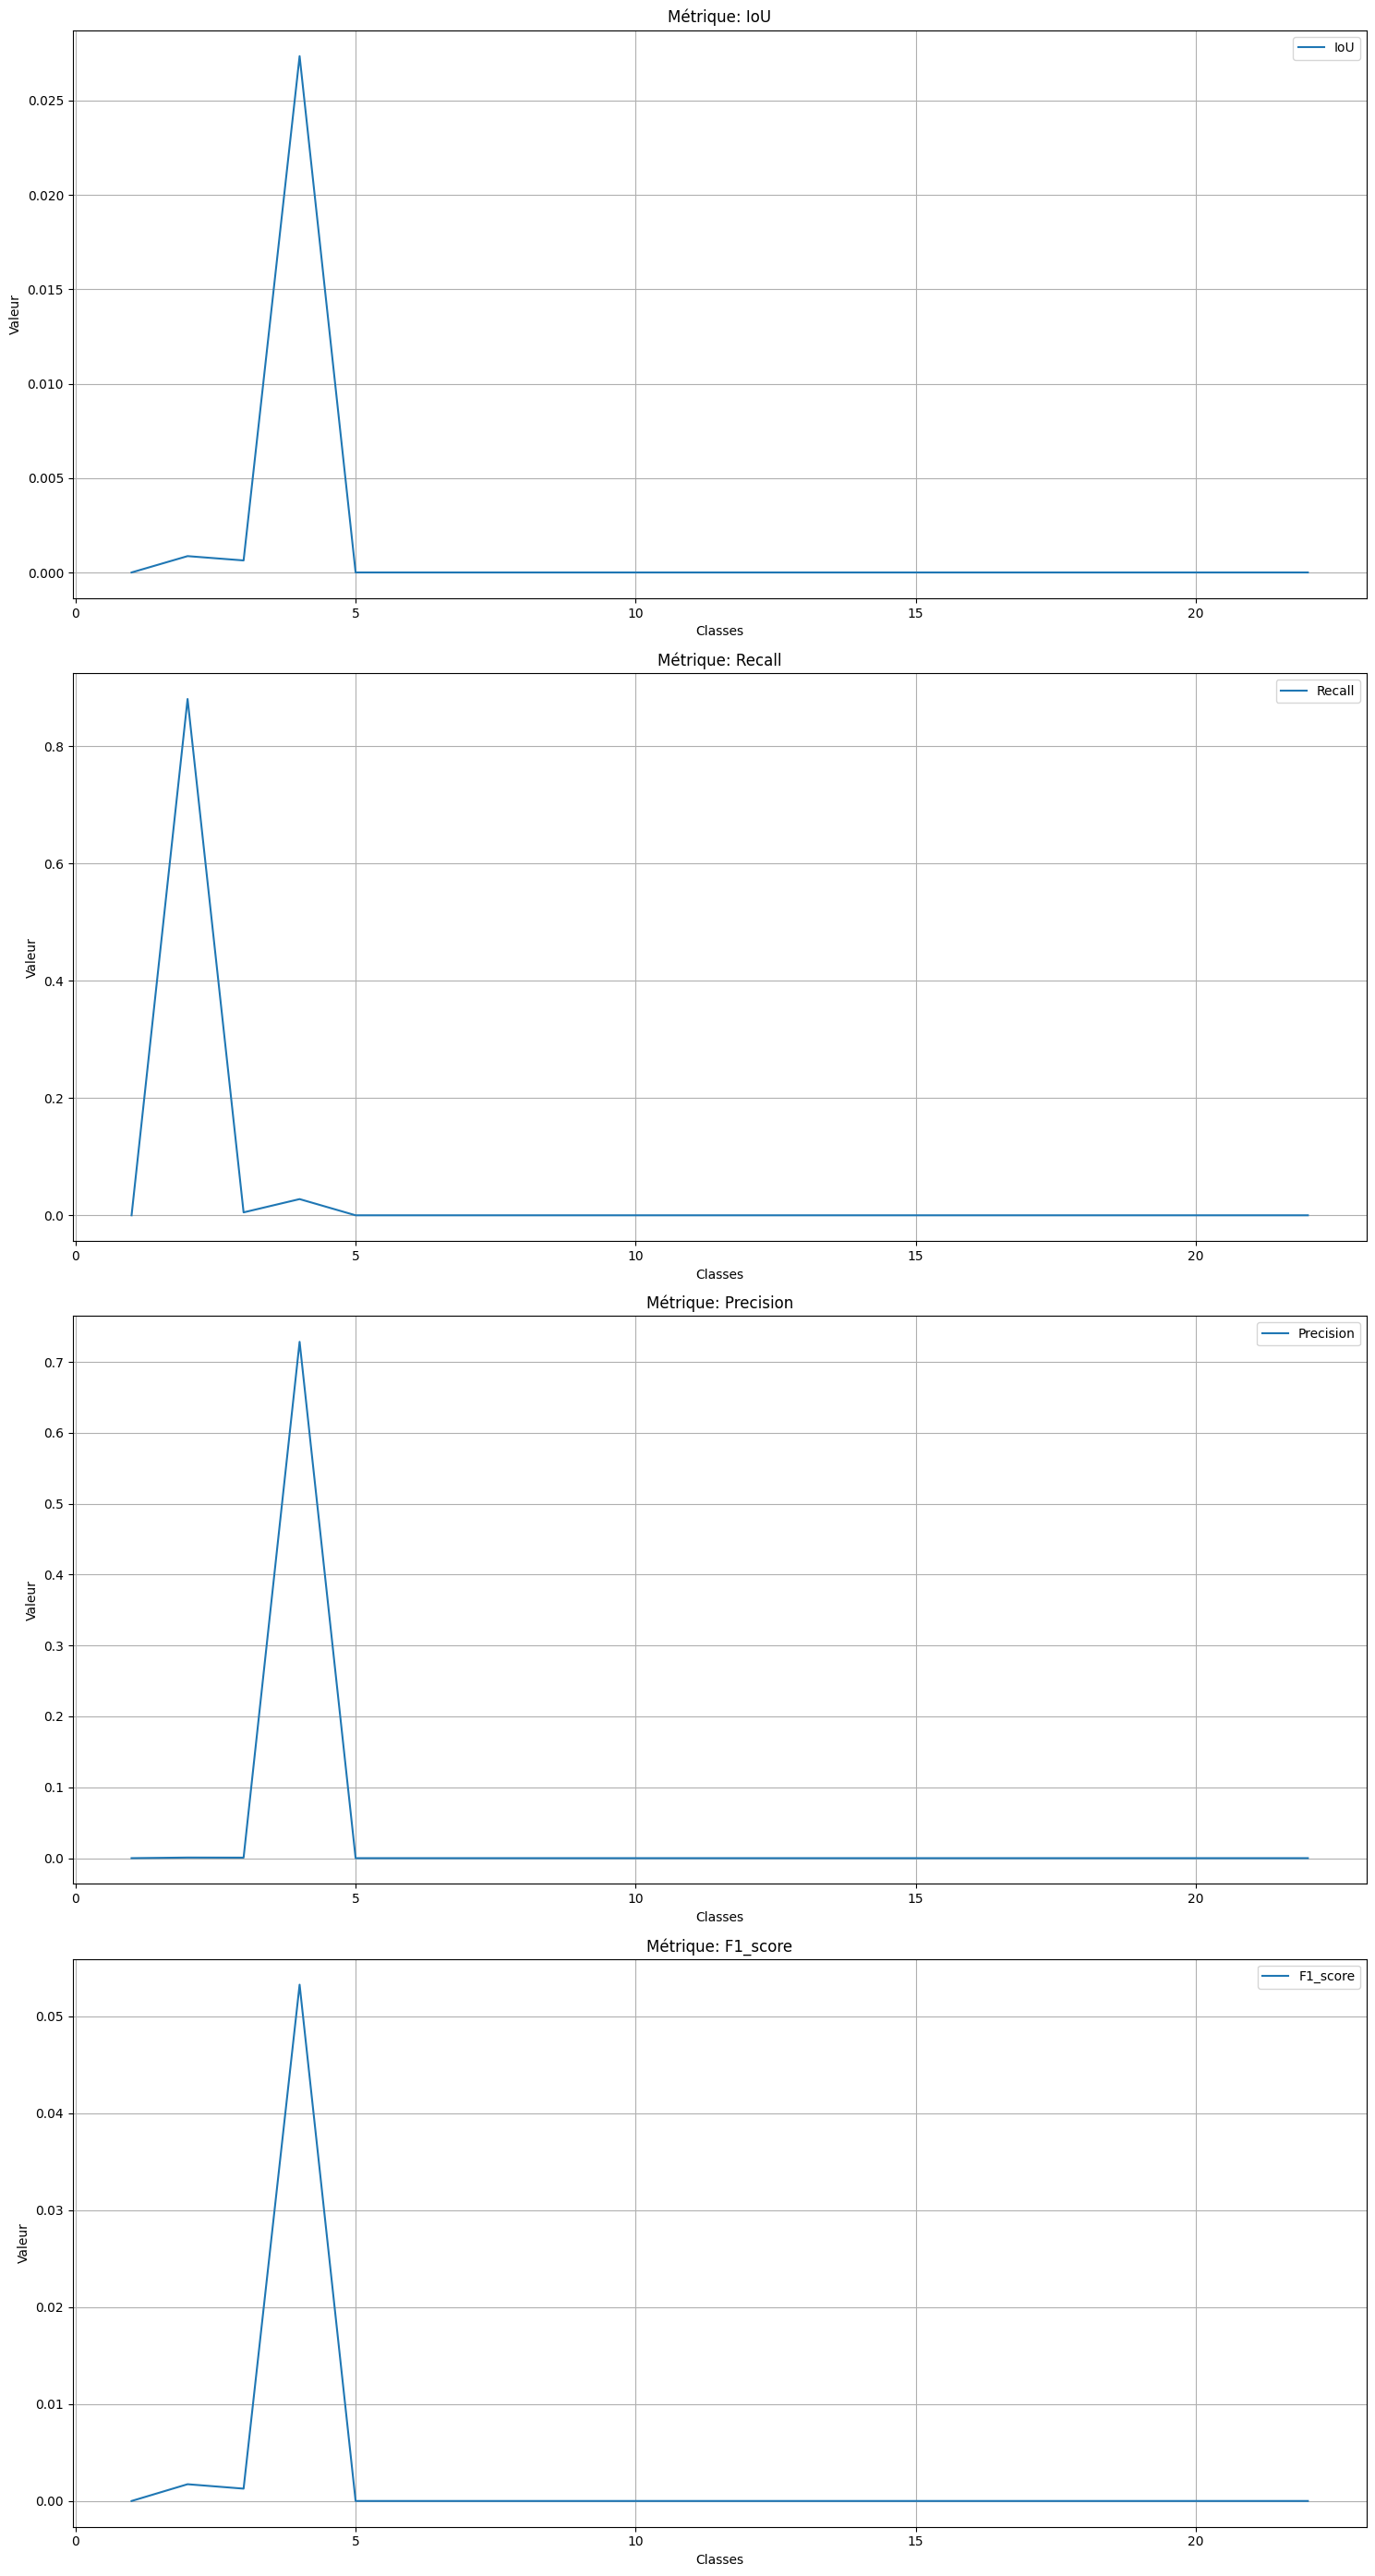

In [98]:

# Exemple d'utilisation
c1=read_file_class(r"E:\RTE_entrainement\IA_Train_Valid_Test\Dev_YSO_py\pred_25.laz")
c2=read_file_class(r"E:\RTE_entrainement\IA_Train_Valid_Test\Dev_YSO_py\before_25.laz")
num_classe1=num_points(c1)
num_classe2=num_points(c2)
predictions = np.array(num_classe1)
ground_truth = np.array(num_classe2)
#class_titles = ["Classe 0", "Classe 1","classes2","classe3"]
#conf_matrix = compute_confusion_matrix(ground_truth,predictions)

print("Matrice de confusion :\n", conf_matrix)

## Instancing
metrics=Metrics(ground_truth,predictions)
## calling a methods for computing metrics
af=metrics.compute_metrics()
metrics.graphmetrics(af)
metrics.n_graphmetrics(af)

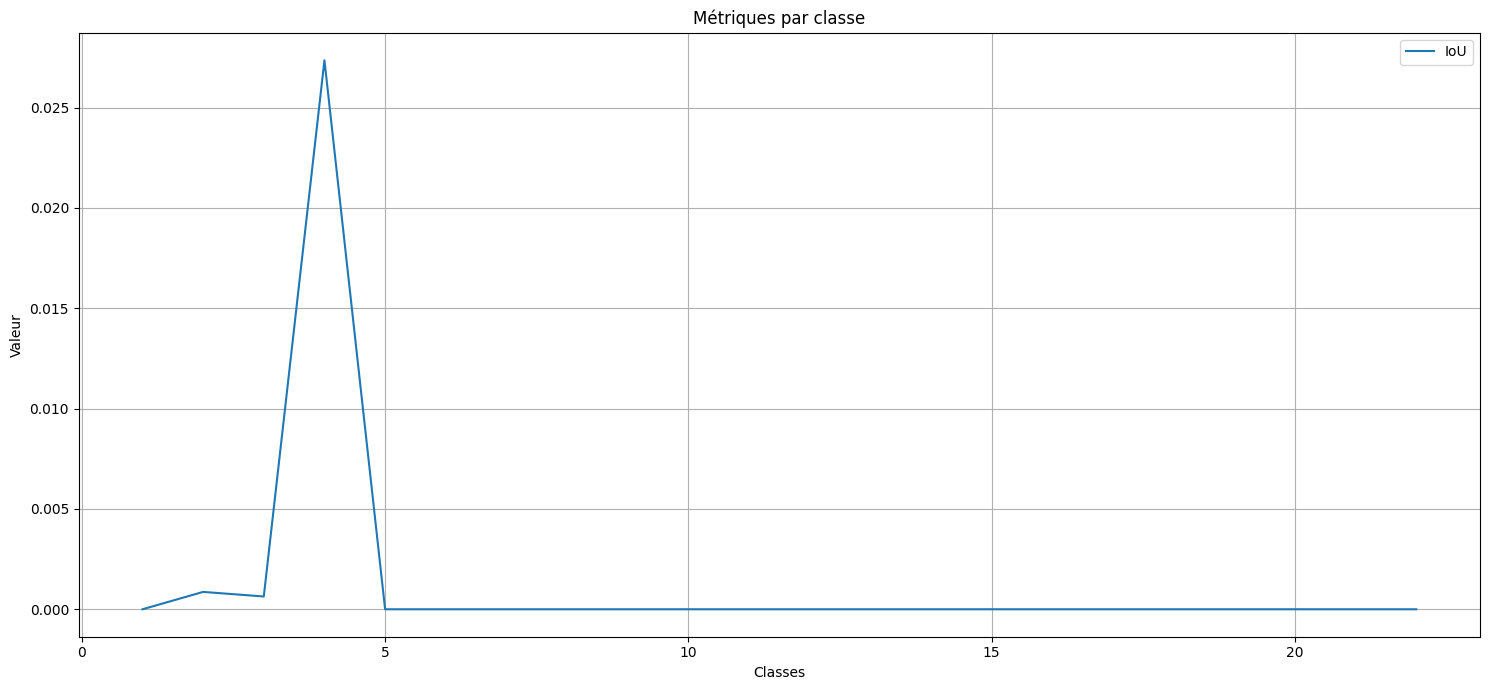

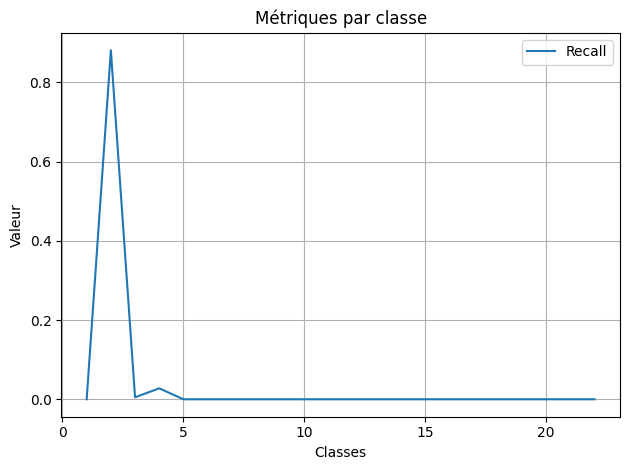

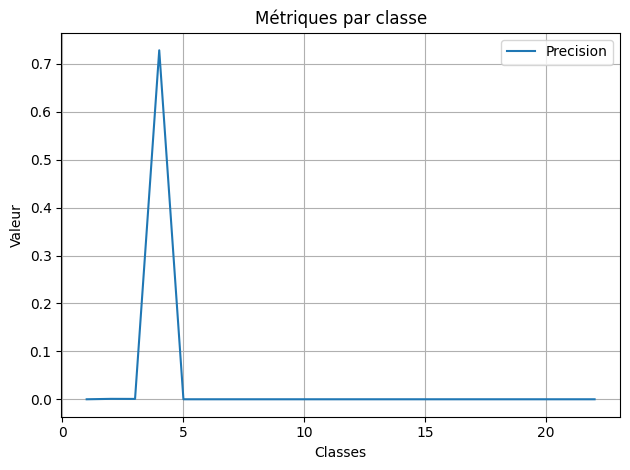

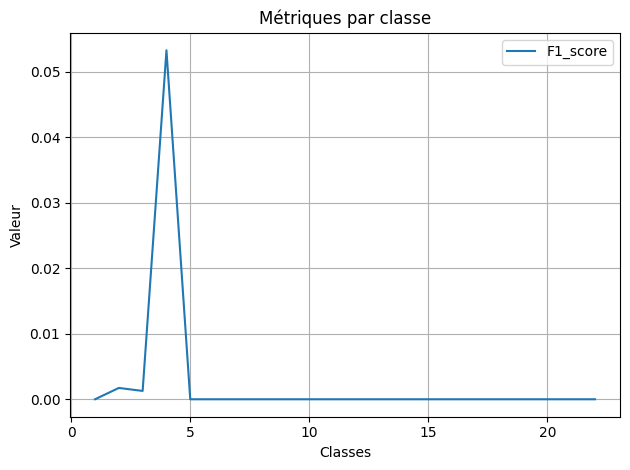

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


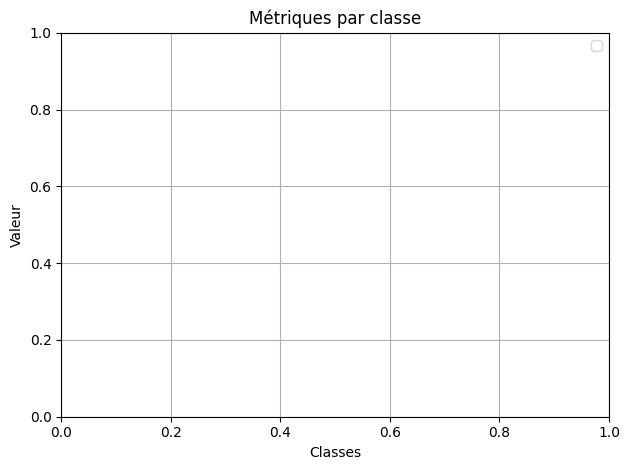

In [96]:
metrics.graphmetrics(af)

In [30]:

"""def confus_matrix(ground_truth,predictions):

    #Calcule la matrice de confusion pour les prédictions et les classes réelles.
    
    #Args:
        #predictions (numpy.ndarray): Tableau des prédictions du modèle.
        #ground_truth (numpy.ndarray): Tableau des classes réelles.
    
    #Returns:
        #pandas.DataFrame: Matrice de confusion avec les index et colonnes représentant les classes.

    # Identifiez les classes uniques présentes dans ground_truth et predictions
    unique_classes = np.unique(np.concatenate((predictions, ground_truth)))

    # Créez une matrice de confusion basée uniquement sur les classes uniques
    confusion_matrix = np.zeros((len(unique_classes), len(unique_classes)))

    # Remplissez la matrice de confusion uniquement pour les classes existantes
    for i in range(len(predictions)):
        pred_class = predictions[i]
        true_class = ground_truth[i]
        pred_index = np.where(unique_classes == pred_class)[0][0]
        true_index = np.where(unique_classes == true_class)[0][0]
        confusion_matrix[pred_index, true_index] += 1

    # Créez des titres de classe basés sur les classes uniques
    #class_titles = [f"Classe {c}" for c in unique_classes]

    # Créez le DataFrame de la matrice de confusion avec les titres de classe
    #conf_matrix_df = pd.DataFrame(confusion_matrix, index=class_titles, columns=class_titles)
    #conf_matrix_df.to_csv('E:\RTE_entrainement\IA_Train_Valid_Test\Test_YSO_py\confusion_matrix.csv')
    return confusion_matrix


def calculate_metrics(conf_matrix):
    # Nombre de classes
    num_classes = conf_matrix.shape[0]
    
    # Initialiser les tableaux pour stocker les résultats
    iou = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    accuracy=np.zeros(num_classes)
# Calculer les métriques pour chaque classe
    for i in range(num_classes):
        
        tp = conf_matrix[i, i]  # Vrais positifs
        fp = np.sum(conf_matrix[:, i]) - tp  # Faux positifs
        fn = np.sum(conf_matrix[i, :]) - tp  # Faux négatifs
        #tn = np.sum(conf_matrix)-(tp+fn+fp) # Vrais positifs
        
        
        
# Intersection over Union (IoU)
        #iou[i] = tp / (tp + fp + fn)
        iou[i]=fIoU(tp,fp,fn)
        # Recall
        #recall[i] = tp / (tp + fn)
        recall[i]=frecall(tp,fn)
        rec=recall[i]
        # Précision
        #precision[i] = tp / (tp + fp)
        precision[i]=fprecision(tp, fp)
        prec=precision[i]
        
        # F1-score
        #f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
        #f1_score[i]=f1_score(fprecision(tp, fp),frecall(tp,fn))
        
        
    # Calculer l'accuracy global
    tp_total = np.sum(np.diag(conf_matrix))  # Somme des vrais positifs pour toutes les classes
    #tn_total = np.sum(conf_matrix) - (tp_total + np.sum(fp) + np.sum(fn))  # Somme des vrais négatifs pour toutes les classes
    total_samples = np.sum(conf_matrix)  # Nombre total d'échantillons
    accuracy = tp_total / total_samples
    #accuracy1=faccuracy(tp,fp,fn)
 
     # Calculer l'accuracy global
    tp_total = np.sum(np.diag(conf_matrix))  # Somme des vrais positifs pour toutes les classes
    total_samples = np.sum(conf_matrix)  # Nombre total d'échantillons
    accuracy = tp_total / total_samples
   
    # Retourner les métriques moyennes ou pondérées
    return {
        'IoUm': np.mean(iou),
        'IoU' : iou,
        'Recallm': np.mean(recall),
        'recall' :  recall,
        'Precisionm': np.mean(precision),
        'Precision' : precision,
        'F1-scorem': np.mean(f1_score),
        'f1_score' : f1_score,
        'Accuracym': np.mean(accuracy)
    }
"""

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\ysouley\AppData\Local\Temp\ipykernel_22860\2400999667.py:1: SyntaxWarning: invalid escape sequence '\R'
  """def confus_matrix(ground_truth,predictions):


'def confus_matrix(ground_truth,predictions):\n\n    #Calcule la matrice de confusion pour les prédictions et les classes réelles.\n    \n    #Args:\n        #predictions (numpy.ndarray): Tableau des prédictions du modèle.\n        #ground_truth (numpy.ndarray): Tableau des classes réelles.\n    \n    #Returns:\n        #pandas.DataFrame: Matrice de confusion avec les index et colonnes représentant les classes.\n\n    # Identifiez les classes uniques présentes dans ground_truth et predictions\n    unique_classes = np.unique(np.concatenate((predictions, ground_truth)))\n\n    # Créez une matrice de confusion basée uniquement sur les classes uniques\n    confusion_matrix = np.zeros((len(unique_classes), len(unique_classes)))\n\n    # Remplissez la matrice de confusion uniquement pour les classes existantes\n    for i in range(len(predictions)):\n        pred_class = predictions[i]\n        true_class = ground_truth[i]\n        pred_index = np.where(unique_classes == pred_class)[0][0]\n  

In [31]:

"""# Exemple d'utilisation
c1=read_file_class(r"E:\RTE_entrainement\IA_Train_Valid_Test\Dev_YSO_py\pred_25.laz")
c2=read_file_class(r"E:\RTE_entrainement\IA_Train_Valid_Test\Dev_YSO_py\before_25.laz")
num_classe1=num_points(c1)
num_classe2=num_points(c2)
predictions = np.array(num_classe1)
ground_truth = np.array(num_classe2)
#class_titles = ["Classe 0", "Classe 1","classes2","classe3"]
confusion_matrix = confus_matrix(ground_truth,predictions)

print("Matrice de confusion :\n", confusion_matrix)
calculate_metrics(confusion_matrix)"""

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\ysouley\AppData\Local\Temp\ipykernel_22860\3972111183.py:1: SyntaxWarning: invalid escape sequence '\R'
  """# Exemple d'utilisation


'# Exemple d\'utilisation\nc1=read_file_class(r"E:\\RTE_entrainement\\IA_Train_Valid_Test\\Dev_YSO_py\\pred_25.laz")\nc2=read_file_class(r"E:\\RTE_entrainement\\IA_Train_Valid_Test\\Dev_YSO_py\x08efore_25.laz")\nnum_classe1=num_points(c1)\nnum_classe2=num_points(c2)\npredictions = np.array(num_classe1)\nground_truth = np.array(num_classe2)\n#class_titles = ["Classe 0", "Classe 1","classes2","classe3"]\nconfusion_matrix = confus_matrix(ground_truth,predictions)\n\nprint("Matrice de confusion :\n", confusion_matrix)\ncalculate_metrics(confusion_matrix)'

Matrice de confusion :
             Classe 0  Classe 1   Classe 2    Classe 3  Classe 4    Classe 5  \
Classe 0         0.0     542.0    17321.0   1466175.0       0.0   2043702.0   
Classe 1         0.0   50901.0  2141540.0  56523912.0       0.0     49454.0   
Classe 2         0.0     668.0    11323.0    467691.0       0.0  14852508.0   
Classe 3         0.0    5665.0    98069.0   1661692.0       0.0    514824.0   
Classe 4         0.0      17.0       87.0       536.0       0.0     54425.0   
Classe 5         0.0       0.0        0.0         0.0       0.0         0.0   
Classe 6         0.0       0.0        0.0         0.0       0.0     20387.0   
Classe 7         0.0       0.0        0.0         0.0       0.0         0.0   
Classe 9         0.0       0.0        0.0         0.0       0.0         0.0   
Classe 14        0.0       0.0        0.0         0.0       0.0         0.0   
Classe 56        0.0       0.0        0.0         0.0       0.0         0.0   
Classe 68        0.0       0

c:\Users\ysouley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ysouley\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'IoU': 0.020479536642343452,
 'Recall': 0.021445884030160105,
 'Precision': 0.5447999340373778,
 'F1-score': 0.039869335158486216,
 'Accuracy': 0.021445884030160105}

In [90]:


# Exemple d'utilisation avec une matrice de confusion
#conf_matrix = np.array([[50, 10], [5, 100]])  # Exemple de matrice de confusion
#metrics = calculate_metrics(conf_matrix)
#print("Métriques :", metrics)


In [91]:
"""
import numpy as np
import pandas as pd
from io import StringIO

# Matrice de confusion sous forme de chaîne de caractères
conf_matrix_str = 
             Classe 0  Classe 1  Classe 2
Classe 0         10         5         0
Classe 1          3        15         2
Classe 2          0         1        20


# Lecture de la matrice de confusion dans un DataFrame pandas
conf_matrix_df = pd.read_csv(StringIO(conf_matrix_str), delim_whitespace=True, index_col=0)

# Conversion du DataFrame en une matrice numpy
conf_matrix = conf_matrix_df.values

# Affichage de la matrice de confusion numpy
print(conf_matrix)

"""

'\nimport numpy as np\nimport pandas as pd\nfrom io import StringIO\n\n# Matrice de confusion sous forme de chaîne de caractères\nconf_matrix_str = \n             Classe 0  Classe 1  Classe 2\nClasse 0         10         5         0\nClasse 1          3        15         2\nClasse 2          0         1        20\n\n\n# Lecture de la matrice de confusion dans un DataFrame pandas\nconf_matrix_df = pd.read_csv(StringIO(conf_matrix_str), delim_whitespace=True, index_col=0)\n\n# Conversion du DataFrame en une matrice numpy\nconf_matrix = conf_matrix_df.values\n\n# Affichage de la matrice de confusion numpy\nprint(conf_matrix)\n\n'

In [11]:
"""
# Exemple d'utilisation
conf_matrix = compute_confusion_matrix(predictions, ground_truth)
precision, recall, f1, accuracy = compute_metrics(conf_matrix)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)
print("Taux d'exactitude:", accuracy)
"""

'\n# Exemple d\'utilisation\nconf_matrix = compute_confusion_matrix(predictions, ground_truth)\nprecision, recall, f1, accuracy = compute_metrics(conf_matrix)\nprint("Précision:", precision)\nprint("Rappel:", recall)\nprint("Score F1:", f1)\nprint("Taux d\'exactitude:", accuracy)\n'

In [20]:
"""
c1=read_file_class(r"E:\RTE_entrainement\IA_Train_Valid_Test\Test_YSO_py\Controle lignes elec-1_YAM.las")
num_classe1=num_points(c1)
predictions = np.array(num_classe1)
#print(type(predictions))
"""

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\ysouley\AppData\Local\Temp\ipykernel_3400\873672617.py:1: SyntaxWarning: invalid escape sequence '\R'
  """


'\nc1=read_file_class(r"E:\\RTE_entrainement\\IA_Train_Valid_Test\\Test_YSO_py\\Controle lignes elec-1_YAM.las")\nnum_classe1=num_points(c1)\npredictions = np.array(num_classe1)\n#print(type(predictions))\n'

44


In [33]:
print(np.diag(conf_matrix))

[6.279367e+06 7.800000e+02 9.114540e+05 1.570000e+02 1.042700e+04
 1.186851e+06 7.188100e+04 8.170000e+03 3.695800e+04 7.597400e+04
 2.566700e+05 2.753000e+03 9.537000e+03 3.829000e+03 3.377000e+03
 3.029000e+03 5.401000e+03 1.217000e+04 3.233400e+04 2.589400e+04
 2.587160e+05 5.345300e+04 5.720300e+04 1.438800e+04 3.561700e+04
 2.850540e+05 2.656700e+04 1.025830e+05 5.677000e+03 5.120530e+05
 5.035620e+05 4.883930e+05 3.996000e+03 3.970000e+03 4.002000e+03]


In [40]:
import sys
import traceback
#import pylas
import laspy
import os
try:
    print('Running LAZ_to_LAS.py')
    
    def convert_laz_to_las(in_laz, out_las):
        las = laspy.read(in_laz)
        las = laspy.convert(las)
        las.write(out_las)        
    
    in_dir = 'E:/S_Données_pour apprentissage/data_post_Pred/Controle lignes elec-1_YAM.laz'
    
    for (dirpath, dirnames, filenames) in os.walk(in_dir):
        for inFile in filenames:
            if inFile.endswith('.laz'):	
                in_laz = os.path.join(dirpath,inFile)
                
                out_las = in_laz.replace('laz', 'las') 
                print('working on file: ',out_las)
                convert_laz_to_las(in_laz, out_las)                            
    print('Finished without errors - LAZ_to_LAS.py')
except:
    tb = sys.exc_info()[2]
    tbinfo = traceback.format_tb(tb)[0]
    print('Error in read_xmp.py')
    print ("PYTHON ERRORS:\nTraceback info:\n" + tbinfo + "\nError Info:\n" + str(sys.exc_info()[1]))    

Running LAZ_to_LAS.py
Finished without errors - LAZ_to_LAS.py


In [39]:
"""
def compute_confusion_matrix(predictions, ground_truth):
    Calcule la matrice de confusion pour les prédictions et les classes réelles.
    
    Args:
        predictions (numpy.ndarray): Tableau des prédictions du modèle.
        ground_truth (numpy.ndarray): Tableau des classes réelles.
    
    Returns:
        pandas.DataFrame: Matrice de confusion avec les index et colonnes représentant les classes.
   
    if len(predictions) == 0 or len(ground_truth) == 0:
        raise ValueError("Les tableaux predictions et ground_truth ne peuvent pas être vides.")
    
    num_classes = max(predictions.max(), ground_truth.max()) + 1
    
    confusion_matrix = np.zeros((num_classes, num_classes))
    
    for pred, truth in zip(predictions, ground_truth):
        confusion_matrix[pred, truth] += 1
    class_titles = [f"Classe {i}" for i in range(num_classes)]
    conf_matrix_df = pd.DataFrame(confusion_matrix, index=class_titles, columns=class_titles)
    return conf_matrix_df
"""

'\ndef compute_confusion_matrix(predictions, ground_truth):\n    Calcule la matrice de confusion pour les prédictions et les classes réelles.\n    \n    Args:\n        predictions (numpy.ndarray): Tableau des prédictions du modèle.\n        ground_truth (numpy.ndarray): Tableau des classes réelles.\n    \n    Returns:\n        pandas.DataFrame: Matrice de confusion avec les index et colonnes représentant les classes.\n   \n    if len(predictions) == 0 or len(ground_truth) == 0:\n        raise ValueError("Les tableaux predictions et ground_truth ne peuvent pas être vides.")\n    \n    num_classes = max(predictions.max(), ground_truth.max()) + 1\n    \n    confusion_matrix = np.zeros((num_classes, num_classes))\n    \n    for pred, truth in zip(predictions, ground_truth):\n        confusion_matrix[pred, truth] += 1\n    class_titles = [f"Classe {i}" for i in range(num_classes)]\n    conf_matrix_df = pd.DataFrame(confusion_matrix, index=class_titles, columns=class_titles)\n    return conf

In [44]:
import numpy as np

def calculate_metrics(conf_matrix):
    # Nombre de classes
    num_classes = conf_matrix.shape[0]
    
    # Initialiser les tableaux pour stocker les résultats
    iou = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    
    # Calculer les métriques pour chaque classe
    for i in range(num_classes):
        TP = conf_matrix[i, i]  # Vrais positifs
        FP = np.sum(conf_matrix[:, i]) - TP  # Faux positifs
        FN = np.sum(conf_matrix[i, :]) - TP  # Faux négatifs
        
        # Intersection over Union (IoU)
        iou[i] = TP / (TP + FP + FN)
        
        # Recall
        recall[i] = TP / (TP + FN)
        
        # Précision
        precision[i] = TP / (TP + FP)
        
        # F1-score
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    
    # Retourner les métriques moyennes ou pondérées
    return {
        'IoU': np.mean(iou),
        'Recall': np.mean(recall),
        'Precision': np.mean(precision),
        'F1-score': np.mean(f1_score)
    }

In [ ]:

import numpy as np

# Exemple de prédictions et d'étiquettes réelles
predictions = np.array([0, 1, 1, 0, 1])
ground_truth = np.array([0, 1, 0, 1, 1])

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(ground_truth, predictions)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
print(conf_matrix)


Matrice de confusion :
[[1 1]
 [1 2]]


In [ ]:
import numpy as np

# Définition des prédictions du modèle
predictions = np.array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1])
# Définition des classes réelles
ground_truth = np.array([0, 1, 1, 0, 1, 1, 0, 0, 0, 1])

# Calcul de la matrice de confusion
confusion_matrix = np.zeros((2, 2))
for i in range(len(predictions)):
    confusion_matrix[predictions[i], ground_truth[i]] += 1

# Affichage de la matrice de confusion
print("Matrice de confusion :")
print(confusion_matrix)


Matrice de confusion :
[[4. 1.]
 [1. 4.]]
